# BIRDS 400 - SPECIES IMAGE CLASSIFICATION
58388Train, 2000 Test, 2000 Validation images 224X224X3 jpg format
Data version 54



## SETUP

Mounting the Google drive:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Getting the dataset

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annatoidze","key":"29b2620f0fbfbe7e1fd3825a7712f0b3"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/muratkokludataset/date-fruit-datasets                                 Date Fruit Datasets                              408KB  2022-04-03 09:25:39           4374        704  0.9375           
datasets/muratkokludataset/acoustic-extinguisher-fire-dataset                  Acoustic Extinguisher Fire Dataset               621KB  2022-04-02 22:59:36            661        621  0.9375           
datasets/muratkokludataset/pistachio-dataset                                   Pistachio Dataset                                  2MB  2022-04-03 08:38:21            410        538  0.9375           


In [ ]:
!kaggle datasets download -d gpiosenka/100-bird-species

 99% 1.49G/1.49G [00:11<00:00, 136MB/s]
100% 1.49G/1.49G [00:11<00:00, 140MB/s]


In [1]:
!unzip 100-bird-species.zip -d /content/gdrive/MyDrive/BIRDS/data/

In [ ]:
!rm 100-bird-species.zip kaggle.json

In [ ]:
!rm -r gdrive/MyDrive/BIRDS/data

### Setting up the libraries

In [4]:
!pip install loguru

     |████████████████████████████████| 58 kB 3.0 MB/s 


In [5]:
import pickle
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
import seaborn as sns

from os.path import join
from loguru import logger
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch import nn
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score

from sklearn.metrics import classification_report
import pandas as pd

In [6]:
DATA_PATH = "/content/gdrive/MyDrive/BIRDS/data/"
RESCALE_SIZE = 224, 224
torch.cuda.empty_cache()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 50 # Maybe try 100 next time?

print(f"Using device: {DEVICE}")

Using device: cuda



## Writing the class *BIRDDataset*

In [7]:
class BIRDDataset(Dataset):
    def __init__(self, files, mode="train") -> None:
        super().__init__()

        self.files = sorted(list(files))
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()
        self.mode = mode

        self.labels = [path.parent.name for path in self.files]
        self.label_encoder.fit(self.labels)

        if self.mode == "train":
            with open("label_encoder.pkl", "wb") as le_dump_file:
                    pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode == "train":
            transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.RandomRotation(degrees=180),
                        # ADDITIONAL AUGMENTATIONS
                        transforms.ToTensor(),
                        #transforms.Normalize([0.572], [0.048])
            ])
        
        else:
            transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.ToTensor(),
                        #transforms.Normalize([0.572], [0.048])
            ])

        x = self.load_sample(self.files[index])
        x = transform(x)
        # if x.shape[0] != 1:
        #     x = x[:3, :, :].mean(dim=0).view(1, *RESCALE_SIZE)

        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()

        return x, y

## Creating class Trainer

In [8]:
class Trainer:
    def __init__(self, model, epochs, criterion,
                 optimizer, trainloader,
                 validloader, device, metric,
                 model_path = "/content/gdrive/MyDrive/BIRDS/models/best_model.pth",
                 validate=True, scheduler=None,
                 verbose=2):
        self.model = model.to(device)
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = trainloader
        self.validloader = validloader
        self.device = device
        self.metric = metric
        self.model_path = model_path
        self.validate = validate
        self.verbose = verbose
        self.scheduler = scheduler
        self.get_probs = nn.Softmax(dim=0)
        self.train_losses = []
        self.valid_losses = []
        self.train_metrics = []
        self.valid_metrics = []

    def fit(self, epochs=None):
        if epochs is None:
            epochs = self.epochs

        for epoch in range(epochs):
            train_loss, train_metric = self._train(self.trainloader)
            self.train_losses.append(train_loss)
            self.train_metrics.append(train_metric)

            if self.validate:
                val_loss, val_metric = self._validate(self.validloader)
                self.valid_losses.append(val_loss)
                self.valid_metrics.append(val_metric)

                if self.scheduler is not None:
                    self.scheduler.step(val_loss)
            else:
                val_loss = "NO"

            if self.verbose > 0:
                print()
                print(f"Epoch {epoch+1} out of {epochs}: Train loss = {train_loss}, validation loss = {val_loss} \n\
                                         Train metric = {train_metric}, validation metric = {val_metric}")
                print()

            # Saving the best model till now
            if self.valid_losses and min(self.valid_losses) ==  val_loss:
              torch.save(self.model.state_dict(), self.model_path)
        
        return self

    def _train(self, loader):
        self.model.train()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            out = self.model(inputs)
            loss = self.criterion(out, targets)
            epoch_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()

            if self.verbose > 1:
                print(f"\rTraining: batch {i+1} out of {len(loader)}", end="")

            self.optimizer.step()

            out = self.get_probs(out)
            _, preds = torch.max(out.data, 1)
            epoch_preds += list(preds.cpu())
            epoch_targets += list(targets.detach().cpu())

            self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric

    def _validate(self, loader):
        self.model.eval()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)              
                out = self.model(inputs)
                loss = self.criterion(out, targets)

                if self.verbose > 1:
                    print(f"\rValidation: batch {i+1} out of {len(loader)}", end="")

                epoch_loss += loss.item()
                out = self.get_probs(out)
                _, preds = torch.max(out.data, 1)
                epoch_preds += list(preds.cpu())
                epoch_targets += list(targets.detach().cpu())

                self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric
    
    def _clear_vram(self, inputs, labels, outputs):
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        outputs = outputs.to("cpu")
        del inputs, labels, outputs
        torch.cuda.empty_cache()

### Create predict and calculate metrics functions

In [9]:

def predict(model, loader):
    model.eval()
    predictions = []
    targ = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)              
            out = model(inputs)
            out = nn.functional.softmax(out, dim=-1)
            _, preds = torch.max(out.data, 1)
            predictions += list(preds)
            targ += list(targets)
    
    return predictions, targ

def calculate_metric(model, loader, metric=None):
    if metric is None:
        metric = accuracy_score
    
    preds, targets = predict(model, loader)
    preds = [i.item() for i in preds]
    targets = [i.item() for i in targets]

    return metric(targets, preds)

### Creating train and validation files

A problem with the dataset - one folder in train data containts two spaces and is recognized as a different class. RUN THIS CODE IF YOU JUST DOWNLOADED THE DATASET.

In [ ]:
# train_files = sorted(list(Path(DATA_PATH + "train/").rglob("*.jpg")))
# val_files = sorted(list(Path(DATA_PATH + "valid/").rglob("*.jpg")))

# train_labels =  [path.parent.name for path in train_files]
# val_labels = [path.parent.name for path in val_files]

# N_CLASSES = len(set(train_labels))
# print(N_CLASSES)

# print(len(set(train_labels)), len(set(val_labels)))
# set(train_labels) ^ set(val_labels)

400
400 400


{'BLACK & YELLOW  BROADBILL', 'BLACK & YELLOW BROADBILL'}

In [ ]:
# !mv /content/gdrive/MyDrive/BIRDS/data/train/'BLACK & YELLOW  BROADBILL' /content/gdrive/MyDrive/BIRDS/data/train/'BLACK & YELLOW BROADBILL'

In [10]:
train_files = sorted(list(Path(DATA_PATH + "train/").rglob("*.jpg")))
val_files = sorted(list(Path(DATA_PATH + "valid/").rglob("*.jpg")))

train_labels =  [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]

N_CLASSES = len(set(train_labels))
N_CLASSES

400

In [ ]:
set(train_labels) ^ set(val_labels)

set()

In [ ]:
print(len(set(train_labels)), len(set(val_labels)))


400 400


### Taking a look at distribution of the classes

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


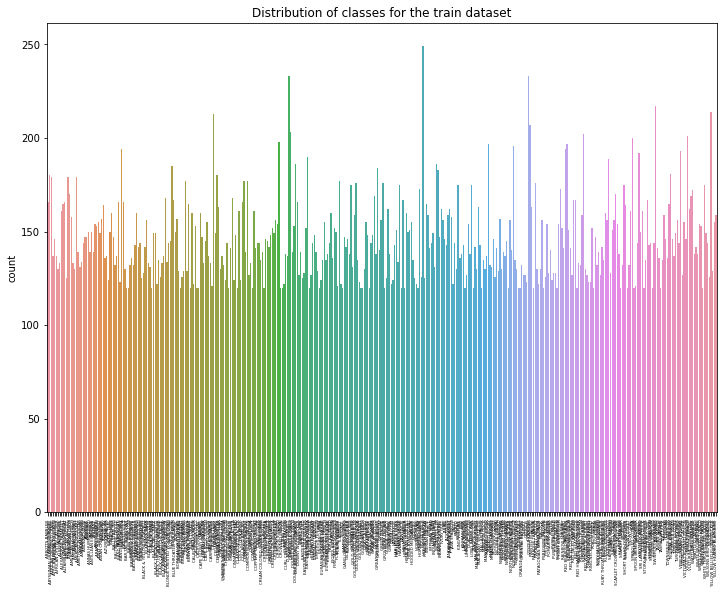

In [11]:
plt.figure(figsize=(12, 9))
sns.countplot(train_labels)
plt.xticks(rotation=90, fontsize=4)
plt.title("Distribution of classes for the train dataset");

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


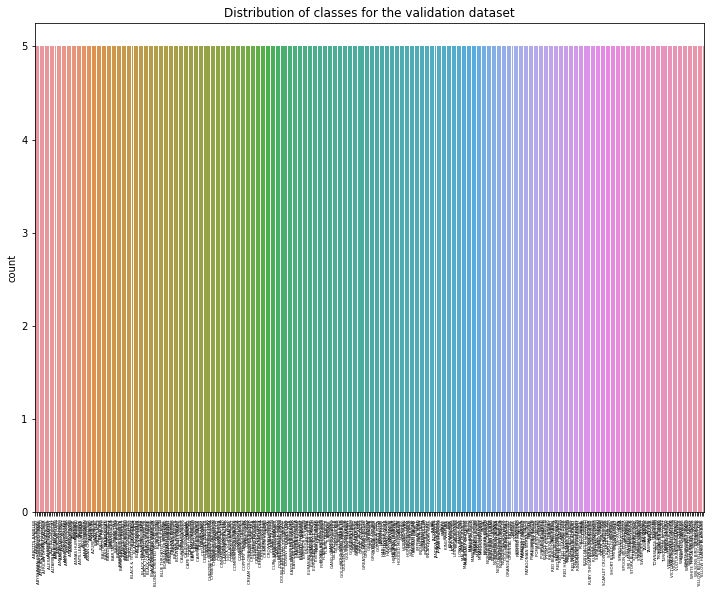

In [12]:
plt.figure(figsize=(12, 9))
sns.countplot(val_labels)
plt.xticks(rotation=90, fontsize=4)
plt.title("Distribution of classes for the validation dataset");

It is looking quite okay. 

In [31]:
trainset = BIRDDataset(train_files)
valset = BIRDDataset(val_files, mode="val")

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

### Getting a model

In [ ]:
model = torchvision.models.vgg19_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

We have 400 classes instead of 1000. So let's correct that.

In [ ]:
num_features = 25088

model.classifier = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=N_CLASSES, bias=True),
        )
model = model.to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Training the model

In [ ]:
trainer = Trainer(model, 20, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score)
# trainer.fit()

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 1 out of 20: Train loss = 4.650018672012303, validation loss = 3.739841675758362 
                                         Train metric = 0.059978077687196, validation metric = 0.0895

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 2 out of 20: Train loss = 3.7363736151832425, validation loss = 2.966093957424164 
                                         Train metric = 0.14684524217304926, validation metric = 0.144

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 3 out of 20: Train loss = 3.0832791795877563, validation loss = 2.2897487938404084 
                                         Train metric = 0.23218812084674934, validation metric = 0.169

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 4 out of 20: Train loss = 2.606540294338579, validation loss = 1.8941302180290223 
                                         Train metric = 0.301877098033842

Here, I went to sleep. I'm continuing with the best model next day. 

In [ ]:
model = torchvision.models.vgg19_bn()
num_features = 25088
model.classifier = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=N_CLASSES, bias=True),
        )
model.load_state_dict(torch.load("/content/gdrive/MyDrive/BIRDS/models/best_model.pth"))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
trainer = Trainer(model, 20, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score)
trainer.fit()

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 1 out of 20: Train loss = 1.0635932247371298, validation loss = 0.6815574847161769 
                                         Train metric = 0.586284853051997, validation metric = 0.2955

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 2 out of 20: Train loss = 0.9766777214683491, validation loss = 0.6725391238927841 
                                         Train metric = 0.5962012742344317, validation metric = 0.277

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 3 out of 20: Train loss = 0.923807379904471, validation loss = 0.594030848890543 
                                         Train metric = 0.6085839556073166, validation metric = 0.296

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 4 out of 20: Train loss = 0.870842366007297, validation loss = 0.5798229206353426 
                                         Train metric = 0.616273891895595,

Here, collab disconnected and decided I had enough time. As we can see, the model would have gotten better, if it had just run longer. But let's load the one we got, and try to predict test data. I saved the new best model as `best_model_16.pth`. Due to the fact that the google collab disconnected every single time, I just copy-pasted the loss values. 

### Loss graph

In [22]:
first_13 = """
Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 1 out of 20: Train loss = 4.650018672012303, validation loss = 3.739841675758362 
                                         Train metric = 0.059978077687196, validation metric = 0.0895

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 2 out of 20: Train loss = 3.7363736151832425, validation loss = 2.966093957424164 
                                         Train metric = 0.14684524217304926, validation metric = 0.144

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 3 out of 20: Train loss = 3.0832791795877563, validation loss = 2.2897487938404084 
                                         Train metric = 0.23218812084674934, validation metric = 0.169

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 4 out of 20: Train loss = 2.606540294338579, validation loss = 1.8941302180290223 
                                         Train metric = 0.30187709803384255, validation metric = 0.183

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 5 out of 20: Train loss = 2.2715795894395816, validation loss = 1.604651728272438 
                                         Train metric = 0.35937178872371034, validation metric = 0.199

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 6 out of 20: Train loss = 2.0112715552318585, validation loss = 1.4090013042092324 
                                         Train metric = 0.40391861341371516, validation metric = 0.2165

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 7 out of 20: Train loss = 1.8036905727157855, validation loss = 1.1560697272419929 
                                         Train metric = 0.44587929026512296, validation metric = 0.2205

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 8 out of 20: Train loss = 1.650665184406385, validation loss = 1.0543577164411544 
                                         Train metric = 0.4718777831061177, validation metric = 0.205

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 9 out of 20: Train loss = 1.503129378267347, validation loss = 1.000985063612461 
                                         Train metric = 0.5006165650476125, validation metric = 0.2225

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 10 out of 20: Train loss = 1.374408441608491, validation loss = 0.8693207748234272 
                                         Train metric = 0.5226758923066384, validation metric = 0.246

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 11 out of 20: Train loss = 1.2841133030820382, validation loss = 0.8046366073191166 
                                         Train metric = 0.5387408371583202, validation metric = 0.2565

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 12 out of 20: Train loss = 1.1884060762822628, validation loss = 0.7728473111987114 
                                         Train metric = 0.5589504692745084, validation metric = 0.2255

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 13 out of 20: Train loss = 1.1132679238201004, validation loss = 0.7000301629304886 
                                         Train metric = 0.5760430225388778, validation metric = 0.245

Training: batch 16 out of 1168
"""

last_13 = """
Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 1 out of 20: Train loss = 1.0635932247371298, validation loss = 0.6815574847161769 
                                         Train metric = 0.586284853051997, validation metric = 0.2955

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 2 out of 20: Train loss = 0.9766777214683491, validation loss = 0.6725391238927841 
                                         Train metric = 0.5962012742344317, validation metric = 0.277

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 3 out of 20: Train loss = 0.923807379904471, validation loss = 0.594030848890543 
                                         Train metric = 0.6085839556073166, validation metric = 0.296

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 4 out of 20: Train loss = 0.870842366007297, validation loss = 0.5798229206353426 
                                         Train metric = 0.616273891895595, validation metric = 0.287

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 5 out of 20: Train loss = 0.8228177629054001, validation loss = 0.5472099613398314 
                                         Train metric = 0.6232616291018702, validation metric = 0.307

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 6 out of 20: Train loss = 0.7769930849540724, validation loss = 0.5476583849638701 
                                         Train metric = 0.6358327053504145, validation metric = 0.2905

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 7 out of 20: Train loss = 0.7464780485487148, validation loss = 0.5159337747842073 
                                         Train metric = 0.6410735082551209, validation metric = 0.318

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 8 out of 20: Train loss = 0.7145599871108385, validation loss = 0.4603792503476143 
                                         Train metric = 0.6479584846201274, validation metric = 0.3155

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 9 out of 20: Train loss = 0.6789395106088829, validation loss = 0.4678149584680796 
                                         Train metric = 0.6565218880591902, validation metric = 0.3175

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 10 out of 20: Train loss = 0.6473766595558965, validation loss = 0.44329312555491923 
                                         Train metric = 0.6645372336781531, validation metric = 0.3245

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 11 out of 20: Train loss = 0.6209096728301008, validation loss = 0.43845634125173094 
                                         Train metric = 0.669161471535247, validation metric = 0.3435

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 12 out of 20: Train loss = 0.6013835210939997, validation loss = 0.4380594927817583 
                                         Train metric = 0.671764746180722, validation metric = 0.3025

Training: batch 1168 out of 1168
Validation: batch 40 out of 40

Epoch 13 out of 20: Train loss = 0.5747112765372412, validation loss = 0.42512568905949594 
                                         Train metric = 0.6779989038843598, validation metric = 0.363

Training: batch 257 out of 1168
"""

In [24]:
first_train_losses = [round(float(i.split(",")[0]), 3) for i in first_13.split("Train loss = ")[1:]]
first_val_losses = [round(float(i.split(" ")[0]), 3) for i in first_13.split("validation loss = ")[1:]]

In [26]:
last_train_losses = [round(float(i.split(",")[0]), 3) for i in last_13.split("Train loss = ")[1:]]
last_val_losses = [round(float(i.split(" ")[0]), 3) for i in last_13.split("validation loss = ")[1:]]

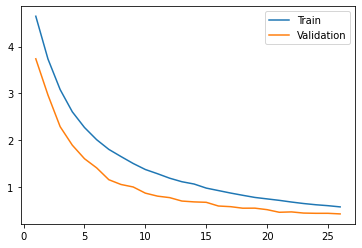

In [27]:
train_losses = first_train_losses + last_train_losses
val_losses = first_val_losses + last_val_losses

sns.lineplot(y=train_losses, x=range(1, 27), label="Train")
sns.lineplot(y=val_losses, x=range(1, 2b7), label="Validation")

plt.show()

## Taking a look at the predictions of the model

In [13]:
model = torchvision.models.vgg19_bn()
num_features = 25088
model.classifier = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=N_CLASSES, bias=True),
        )
model.load_state_dict(torch.load("/content/gdrive/MyDrive/BIRDS/models/best_model_26.pth"))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [63]:
model = model.to(DEVICE)

In [28]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()

    return probs


def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp.reshape(*RESCALE_SIZE), cmap="gray")
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


def get_predicts(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

    return probs


In [32]:
label_encoder = trainset.label_encoder


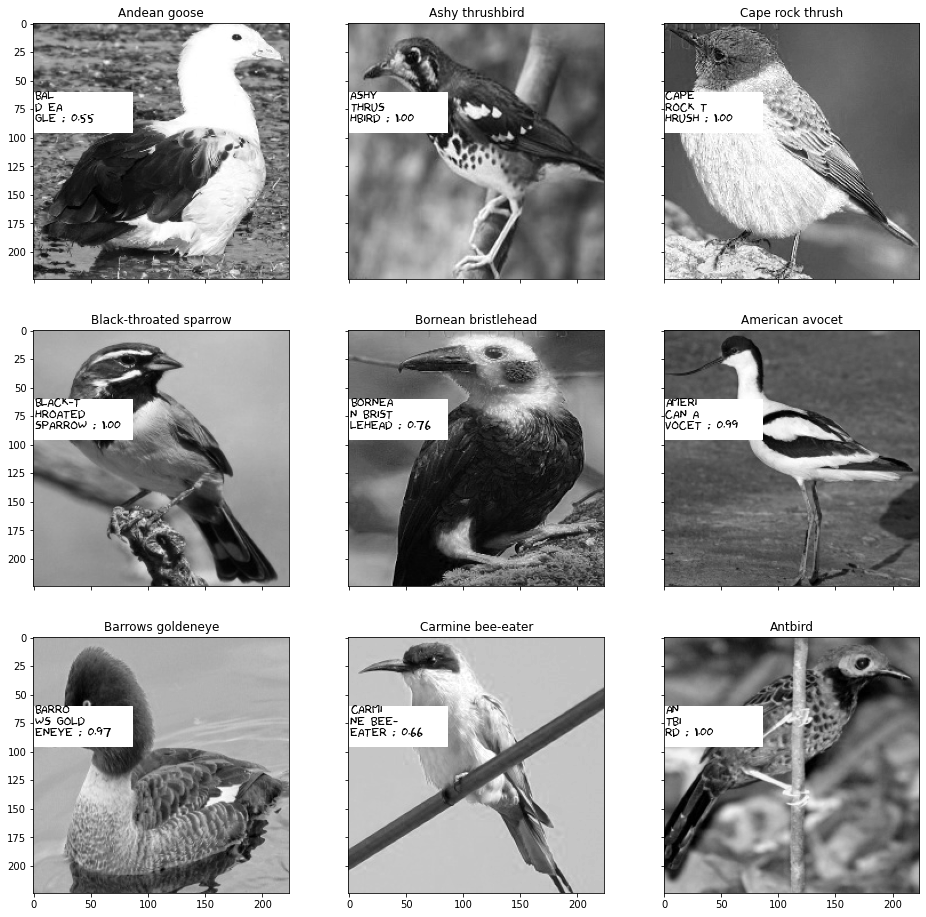

In [72]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 500))
    im_val, label = valset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                valset.label_encoder.inverse_transform([label])[0].split("_")))
    
    

    imshow(im_val.data.cpu()[0], \
          title=img_label, plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 60), 86, 35, color="white"))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//3] + "\n" + \
      predicted_label[len(predicted_label)//3:len(predicted_label) - len(predicted_label)//3] + "\n" + \
      predicted_label[len(predicted_label) - len(predicted_label)//3:]
    predicted_text = "{} : {:.2f}".format(predicted_label, predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment="left", fontproperties=font,
                    verticalalignment="top", fontsize=14, color="black", fontweight="bold",
                    size='large')

In [75]:
val_images = [valset[id][0].unsqueeze(0) for id in range(len(valset))]
val_predictions = get_predicts(model, val_images)

y_pred_val = np.argmax(val_predictions, -1)
actual_labels = [valset[id][1] for id in range(len(valset))]
preds_class = [label_encoder.classes_[i] for i in y_pred_val]

val_mertics_report = pd.DataFrame(classification_report(actual_labels, y_pred_val, output_dict=True)).T

In [77]:
val_mertics_report.index = list(label_encoder.inverse_transform(np.arange(400))) + ["accuracy", "macro avg", "weighted avg"]
val_mertics_report

,precision,recall,f1-score,support
ABBOTTS BABBLER,1.000000,0.600,0.750000,5.000
ABBOTTS BOOBY,1.000000,0.400,0.571429,5.000
ABYSSINIAN GROUND HORNBILL,0.714286,1.000,0.833333,5.000
AFRICAN CROWNED CRANE,1.000000,0.600,0.750000,5.000
AFRICAN EMERALD CUCKOO,1.000000,0.600,0.750000,5.000
...,...,...,...,...
YELLOW CACIQUE,0.714286,1.000,0.833333,5.000
YELLOW HEADED BLACKBIRD,1.000000,0.800,0.888889,5.000
accuracy,0.885000,0.885,0.885000,0.885
macro avg,0.908435,0.885,0.882449,2000.000


In [79]:
val_mertics_report.sort_values("f1-score").head(20)

,precision,recall,f1-score,support
WHITE NECKED RAVEN,1.000000,0.2,0.333333,5.0
ALBATROSS,0.500000,0.4,0.444444,5.0
CALIFORNIA CONDOR,0.666667,0.4,0.500000,5.0
MASKED BOOBY,0.666667,0.4,0.500000,5.0
SWINHOES PHEASANT,0.500000,0.6,0.545455,5.0
CHARA DE COLLAR,1.000000,0.4,0.571429,5.0
HIMALAYAN MONAL,1.000000,0.4,0.571429,5.0
HORNED GUAN,1.000000,0.4,0.571429,5.0
AZURE JAY,1.000000,0.4,0.571429,5.0
PURPLE FINCH,1.000000,0.4,0.571429,5.0


## Test data

In [85]:
test_files = sorted(list(Path(DATA_PATH + "test/").rglob("*.jpg")))
test_labels = [path.parent.name for path in test_files]

N_CLASSES = len(set(test_labels))
N_CLASSES

400

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


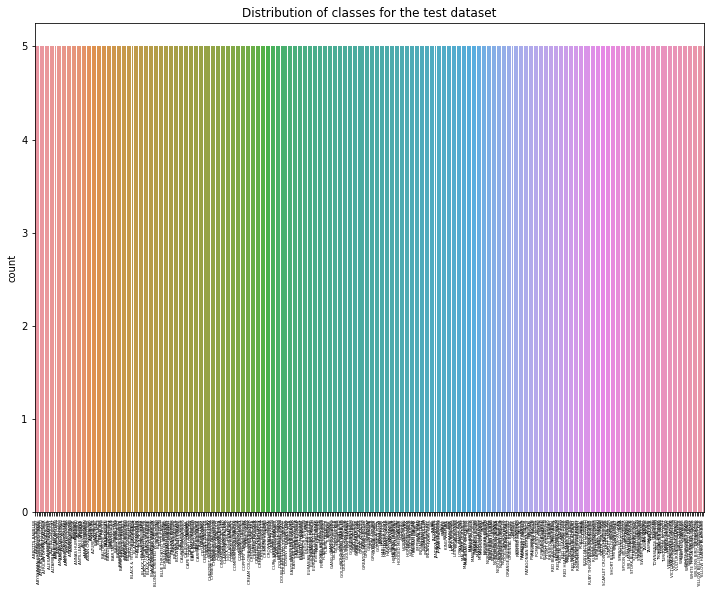

In [87]:
plt.figure(figsize=(12, 9))
sns.countplot(test_labels)
plt.xticks(rotation=90, fontsize=4)
plt.title("Distribution of classes for the test dataset");

In [94]:
testset = BIRDDataset(test_files, mode="test")

testloader = DataLoader(testset, batch_size=1, shuffle=False)


In [96]:
calculate_metric(model, testloader)

0.9105